In [165]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score, root_mean_squared_error, r2_score, mean_absolute_error
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import skew, norm, probplot

df = pd.read_csv('data/real_estate_belguim_features.csv', sep=',') 

# Decision tree + Random Forest

In [166]:
df.shape

(17367, 20)

* Apply log1p transformation to 'price' column

In [ ]:
# log1p to 'price' column
#df["price"] = np.log1p(df["price"])

# Plot distribution
#sns.histplot(df['price'], kde=True, stat='density', color='blue')

# Parameters normal distribution
#(mu, sigma) = norm.fit(df['price'])
#print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Plot normal distribution
#xmin, xmax = plt.xlim()
#x = np.linspace(xmin, xmax, 100)
#p = norm.pdf(x, mu, sigma)
#plt.plot(x, p, 'k', linewidth=2)
#plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
#plt.ylabel('Density')
#plt.title('SalePrice distribution')
#plt.show()

# QQ-plot
#fig = plt.figure()
#res = probplot(df['price'], plot=plt)  # Use probplot instead of stats.probplot
#plt.show()

In [168]:
# Encode state_of_the_building as Ordinal value, where the best the state the higher the value. 
encoder = OrdinalEncoder()
state = ["renovatiom", "good", "excellent"]
state = np.array(state).reshape(-1,1)
encoded = encoder.fit_transform(state) 

# Columns to encode
columns_to_encode = ['state_of_the_building']  
df['state_of_the_building']  = encoder.fit_transform(df[['state_of_the_building']])

In [169]:
# Numerical features and categorical features
categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude=["object"]).drop("price", axis=1).columns

df_numerical = df[numerical_features]
df_categorical = df[categorical_features]

print("Numerical features: " + str(len(numerical_features)))
print("Categorical features: " + str(len(categorical_features)))

Numerical features: 15
Categorical features: 4


In [170]:
# Find skewed features
df_numerical = df_numerical.astype(np.float64)
skewness = df_numerical.apply(lambda x: skew(x, nan_policy='omit'))
skewed_features = skewness[abs(skewness) > 0.5].index

print(f"Skewed numerical features: {len(skewed_features)}")

# Log transform the skewed numerical features 
#df_numerical[skewed_features] = df_numerical[skewed_features].apply(np.log1p)

Skewed numerical features: 11


In [ ]:
# Concatenate categorical_features and numerical
categorical_features_df = df[categorical_features]
complete_features = pd.concat([df_numerical, categorical_features_df], axis=1)
print(complete_features.shape)

(17367, 19)


In [172]:
#complete_features_dummies = pd.get_dummies(complete_features,drop_first=True)
#df = pd.concat([complete_features_dummies, df['price']], axis = 1)

In [ ]:
# Ordinal encoding for categorical features (random as these columns has no real order)
for column in categorical_features_df :
    unique_categories = complete_features[column].unique()
    np.random.shuffle(unique_categories)  
    category_map = {category: idx for idx, category in enumerate(unique_categories)}
    complete_features[column] = complete_features[column].map(category_map)

# Add 'price' columns
df = pd.concat([complete_features, df['price']], axis=1)

In [174]:
df

,longitude,latitude,crime_rate,population_km,prosperity_index,state_of_the_building,number_of_rooms,living_area,fully_equipped_kitchen,furnished,open_fire,number_of_facades,swimming_pool,ext_area,postal_code,province,type_of_property,municipality,subtype_of_property,price
0,50.930129,4.428578,22.742122,2199.232426,92.0,1.0,3.0,400.0,0.0,0.0,0.0,2.0,0.0,0.0,1800.0,6,0,32,15,475000
1,51.248448,4.376134,38.339890,2666.254939,87.0,1.0,3.0,286.0,1.0,0.0,0.0,2.0,0.0,30.0,2000.0,7,0,80,10,895000
2,51.090212,2.972217,9.176391,223.812277,98.0,0.0,3.0,120.0,0.0,0.0,0.0,1.0,0.0,4.0,8680.0,2,0,295,1,289000
3,51.263556,4.682858,13.609966,583.095609,121.0,2.0,4.0,350.0,0.0,0.0,0.0,4.0,0.0,0.0,2980.0,7,1,163,16,775000
4,51.121347,2.700627,21.628144,427.834883,137.0,2.0,4.0,148.0,0.0,1.0,0.0,2.0,0.0,0.0,8670.0,2,0,194,10,1495000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17362,51.108205,2.779552,32.213007,344.161951,110.0,1.0,1.0,63.0,0.0,0.0,0.0,2.0,0.0,0.0,8620.0,2,0,90,0,275000
17363,51.053261,3.720262,45.408517,1708.806368,103.0,1.0,5.0,330.0,0.0,0.0,0.0,2.0,0.0,69.0,9000.0,8,1,152,3,799000
17364,49.612381,5.653187,6.727664,102.508642,110.0,2.0,5.0,260.0,0.0,0.0,0.0,4.0,0.0,1630.0,6747.0,5,1,309,7,295000
17365,50.828980,4.292904,50.410409,7066.037736,62.0,1.0,1.0,140.0,0.0,0.0,1.0,2.0,0.0,10.0,1070.0,0,0,92,1,350000


* Splitting the data into train and test 

In [175]:
X = df.drop('price', axis=1)
y = df['price'].values.reshape(-1,1)

print("x:", X.shape)
print("y:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

x: (17367, 19)
y: (17367, 1)


#### Decision tree

In [ ]:
# Decision Tree Regression model
tr_regressor = DecisionTreeRegressor(random_state=100, max_depth=8, max_leaf_nodes=93)

# Fitting the model 
tr_regressor.fit(X_train,y_train)

# Predicting
y_pred_tr_regressor = tr_regressor.predict(X_test)

In [ ]:
# Evaluation metrics

# Explained Variance Score
# Evaluates how much variance in y_test is explained by the predictions (pred_tr).
#Unlike R², this metric focuses on the variance explained without penalizing the model for bias.
expl_tr = explained_variance_score(y_pred_tr_regressor,y_test)
print(f'Explained Variance Score: {expl_tr}')

# RMSE (Root Mean Square Error)
rmse_ = root_mean_squared_error(y_test, y_pred_tr_regressor)
print("\nRMSE: ", rmse_)

# MAE (Mean absolute error)
mae_ = mean_absolute_error(y_test, y_pred_rf_regressor)
print("MAE: ", mae_)

# Accurancy
print('Accuracy on training set: {:3f}'.format(tr_regressor.score(X_train,y_train)))
print('Accuracy on test set: {:3f}'.format(tr_regressor.score(X_test,y_test)))

Explained Variance Score: 0.43841774879787554

RMSE:  155158.05580500263
MAE:  83000.38828853749
Accuracy on training set: 0.671892
Accuracy on test set: 0.635131


In [178]:
# Parameters used by tr_regressor
print('Parameters currently in use:\n')
print(tr_regressor.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': 93, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 100, 'splitter': 'best'}


Text(0.5, 1.0, 'Actual vs Predicted')

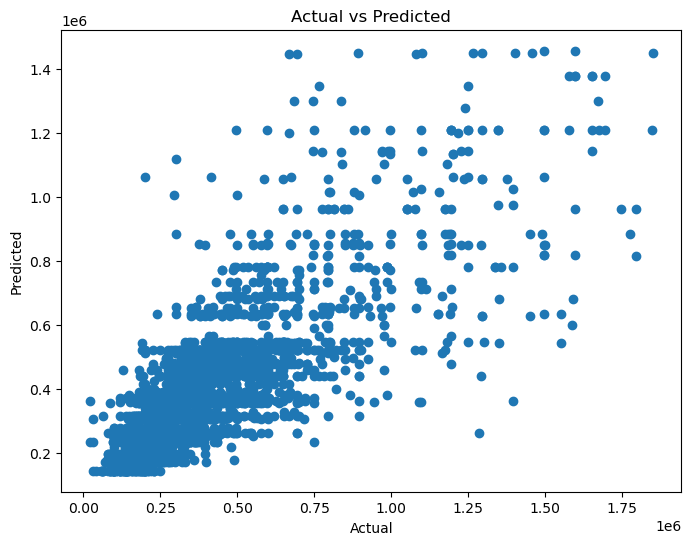

In [179]:
plt.figure(figsize=(8,6))
plt.scatter(y_test,y_pred_tr_regressor)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Actual vs Predicted')

In [ ]:
# 1-dimensional y_test and pred_tr
y_test_1d = y_test.ravel() if len(y_test.shape) > 1 else y_test
pred_tr_1d = y_pred_tr_regressor.ravel() if len(y_pred_tr_regressor.shape) > 1 else y_pred_tr_regressor


pred_y_df = pd.DataFrame({
    'Actual Values': y_test_1d,
    'Predicted Value': pred_tr_1d,
    'Difference': y_test_1d - pred_tr_1d
})

pred_y_df[0:20]

,Actual Values,Predicted Value,Difference
0,210000,309256.493573,-99256.493573
1,145000,234439.652866,-89439.652866
2,319000,265028.647810,53971.352190
3,299000,401180.882353,-102180.882353
4,1290000,441123.975410,848876.024590
5,625000,478478.830287,146521.169713
6,290000,441123.975410,-151123.975410
7,259000,262962.366091,-3962.366091
8,174000,172888.569444,1111.430556
9,120000,145818.823105,-25818.823105


#### Random Forest Regression Model

In [ ]:
#Random Forest Regression model
rf_regressor = RandomForestRegressor(random_state=200, max_depth=16)

# Fitting the model 
rf_regressor.fit(X_train,y_train)

# Predicting
y_pred_rf_regressor =rf_regressor.predict(X_test)

/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
# Evaluation metrics

# Explained Variance Score
# Evaluates how much variance in y_test is explained by the predictions (pred_tr).
#Unlike R², this metric focuses on the variance explained without penalizing the model for bias.
expl_rf = explained_variance_score(y_pred_rf_regressor,y_test)
print(f'Explained Variance Score: {expl_rf}')

# RMSE (Root Mean Square Error)
rmse = root_mean_squared_error(y_test, y_pred_rf_regressor)
print("\nRMSE: ", rmse)

# MAE (Mean absolute error)
mae_ = mean_absolute_error(y_test, y_pred_tr_regressor)
print("MAE: ", mae_)

# Accurancy
print('Accuracy on training set: {:3f}'.format(rf_regressor.score(X_train,y_train)))
print('Accuracy on test set: {:3f}'.format(rf_regressor.score(X_test,y_test)))

Explained Variance Score: 0.6217182093649827

RMSE:  132746.5762333721
MAE:  101069.39308747255
Accuracy on training set: 0.934412
Accuracy on test set: 0.732924


In [183]:
# Parameters used by rf_regressor
print('Parameters currently in use:\n')
print(rf_regressor.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 16, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 200, 'verbose': 0, 'warm_start': False}


Text(0.5, 1.0, 'Actual vs Predicted')

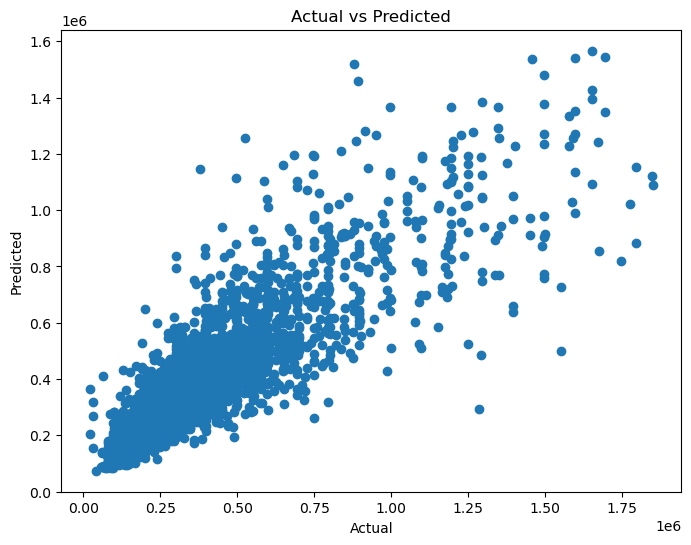

In [184]:
plt.figure(figsize=(8,6))
plt.scatter(y_test,y_pred_rf_regressor)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Actual vs Predicted')

In [ ]:
# 1-dimensional y_test and pred_tr
y_test_1d = y_test.ravel() if len(y_test.shape) > 1 else y_test
pred_tr_1d = y_pred_rf_regressor.ravel() if len(y_pred_rf_regressor.shape) > 1 else y_pred_rf_regressor


pred_y_df = pd.DataFrame({
    'Actual Values': y_test_1d,
    'Predicted Value': pred_tr_1d,
    'Difference': y_test_1d - pred_tr_1d
})

pred_y_df[0:20]

,Actual Values,Predicted Value,Difference
0,210000,243853.583868,-33853.583868
1,145000,201504.540367,-56504.540367
2,319000,304721.013386,14278.986614
3,299000,351171.000000,-52171.000000
4,1290000,486695.940209,803304.059791
5,625000,498976.255717,126023.744283
6,290000,343707.394649,-53707.394649
7,259000,287626.849746,-28626.849746
8,174000,197216.969007,-23216.969007
9,120000,139929.567048,-19929.567048


***

In [ ]:
# RandomForestRegressor model
model = RandomForestRegressor(random_state=10)

# Hyperparameters grid
param_grid = {
    'n_estimators': [10, 50, 100],       
    'max_depth': [None, 10, 20, 30],    
    'min_samples_split': [2, 5, 10]      
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid 
grid_search.fit(X_train, y_train)

# Get the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Use the best to predict 
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-p

KeyboardInterrupt: 

In [ ]:
rf_reg = RandomForestRegressor(random_state=10)

param_grid = { 
    'n_estimators': [46,47,48,49,50,51,52],
    'min_samples_split': [11,12,13],
    'min_samples_leaf' : [4,5,6],
    'max_depth' : [5,6,7,8,9,10]
}

gs_rf = GridSearchCV(rf_reg, param_grid, cv= 5)
gs_rf.fit(X_train,y_train)

gs_rf.best_params_

/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-p

KeyboardInterrupt: 

In [ ]:
rf_reg_best = RandomForestRegressor(random_state=10, max_depth=10, min_samples_leaf=4, min_samples_split=11, n_estimators=51)
rf_reg_best.fit(X_train, y_train)
y_pred2 = rf_reg_best.predict(X_test)

In [ ]:
# Evaluation metrics

# Explained Variance Score
# Evaluates how much variance in y_test is explained by the predictions (pred_tr).
#Unlike R², this metric focuses on the variance explained without penalizing the model for bias.
expl_rf = explained_variance_score(y_pred2,y_test)
print(f'Explained Variance Score: {expl_rf}')

# RMSE (Root Mean Square Error)
rmse = root_mean_squared_error(y_test, y_pred2)
print("\nRMSE: ", rmse)

# MAE (Mean absolute error)
mae_ = mean_absolute_error(y_test, y_pred2)
print("MAE: ", mae_)


# Accurancy
print('Accuracy on training set: {:3f}'.format(rf_reg_best.score(X_train,y_train)))
print('Accuracy on test set: {:3f}'.format(rf_reg_best.score(X_test,y_test)))